In [10]:
# Importing neccesary Libraries

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import itertools
warnings.filterwarnings("ignore")

In [4]:
# Reading data

df = pd.read_csv('portland-oregon-average-monthly-.csv', index_col=0)
df.index.name=None
df.reset_index(inplace=True)

In [5]:
df.head()

,index,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630


In [11]:
# Making date column as index column

start = datetime.datetime.strptime("1973-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,114)]
df['index'] =date_list
df.set_index(['index'], inplace=True)
df.index.name=None

In [12]:
# Converting number of rides in acaul rides by multipying by 100

df.columns= ['riders']
df['riders'] = df.riders.apply(lambda x: int(x)*100)

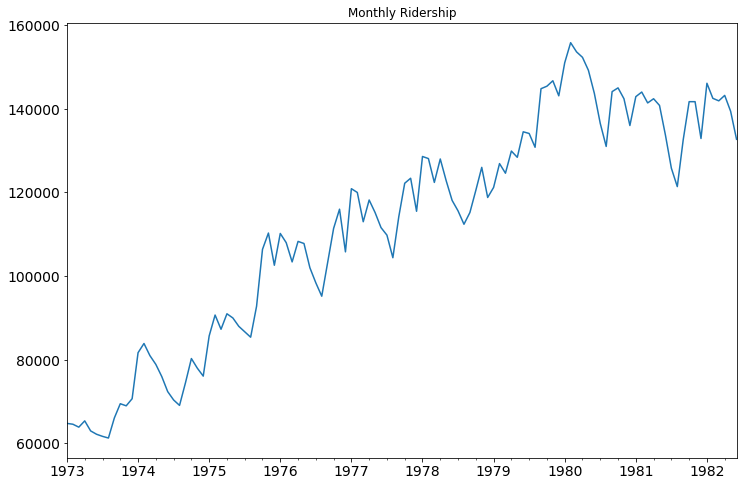

In [13]:
# Visualizing the data

df.riders.plot(figsize=(12,8), title= 'Monthly Ridership', fontsize=14)
plt.savefig('month_ridership.png', bbox_inches='tight')

**As we visualize the Portland public transit data we can see there is both an upward trend in the data and there is seasonality to it.**<br>

**We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.**

<Figure size 432x288 with 0 Axes>

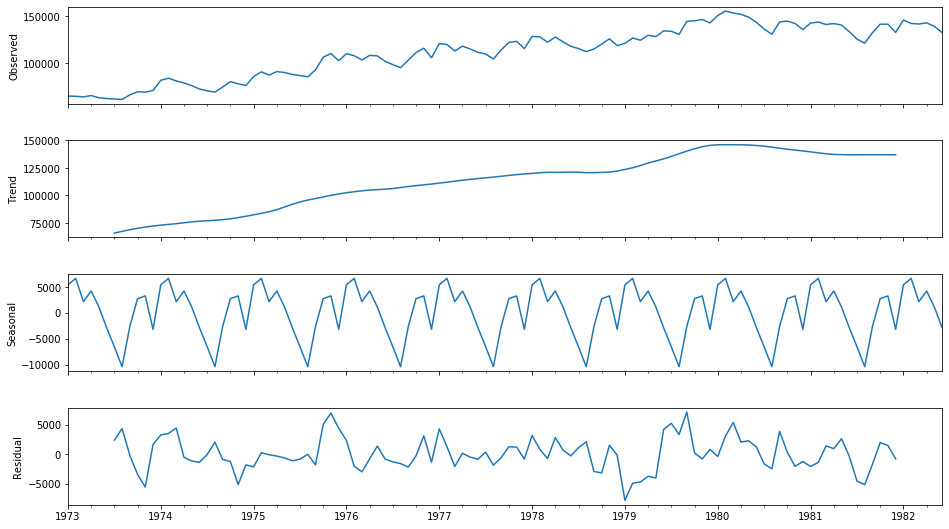

In [14]:
decomposition = seasonal_decompose(df.riders, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

 
 **Seasonal ARIMA models are denoted with the notation SARIMA(p, d, q), (P,D,Q)m.**

In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


**This step is parameter Selection for seasonal ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.**

In [18]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df.riders.astype(float),
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2957.370554564166
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2595.3864799152752
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2207.2528528426296
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1948.4272063544497
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2200.3535348493824
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2178.6806032356326
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1962.501941516448
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1914.1233243544557
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2853.2769858242063
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2533.1765853415304
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2117.1099377764617
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1881.669463901755
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2573.6551143511074
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2525.238546069386
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1904.5512544453725
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1857.3115123852222
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2257.9013343455426
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1976.4923786202

**The above output suggests that SARIMAX(0, 1, 1)x(0, 1, 1, 12) yields the lowest AIC value of 1688.69 and 
SARIMAX(0, 1, 1)x(1, 1, 1, 12) yields the AIC value of 1690.39. Therefore we should consider these two to be optimal option.**

In [21]:
## Manually finding the optimum values of Sarima parameters using adfuller test and ACF and PACF to cross verify

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean=pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Moving Average')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Moving Average')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

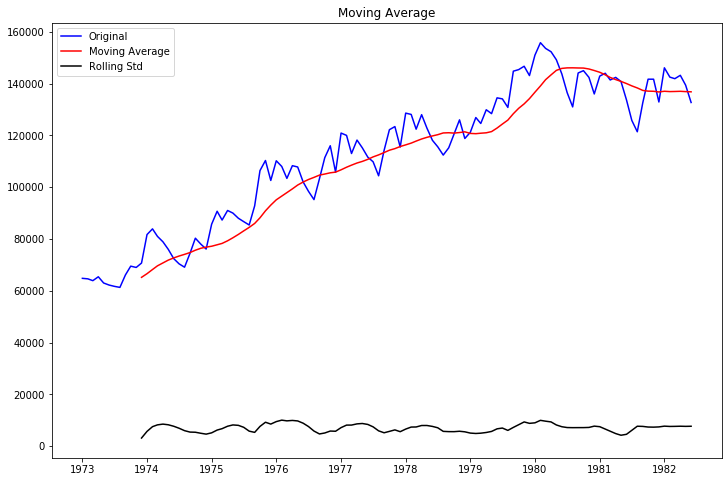

Results of Dickey-Fuller Test:
Test Statistic                  -1.536597
p-value                          0.515336
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [22]:
test_stationarity(df.riders)

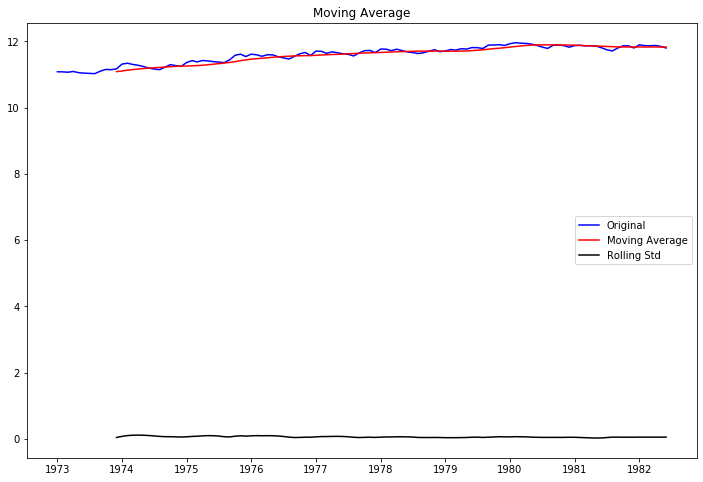

Results of Dickey-Fuller Test:
Test Statistic                  -1.677830
p-value                          0.442570
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [23]:
# Using Log of target variable

df['riders_log']= df.riders.apply(lambda x: np.log(x))  
test_stationarity(df.riders_log)

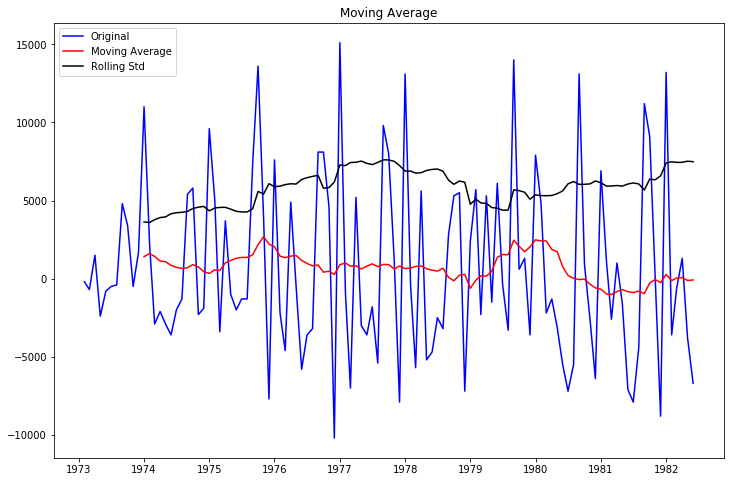

Results of Dickey-Fuller Test:
Test Statistic                  -1.938696
p-value                          0.314082
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [24]:
# First Difference to remove trend

df['first_difference'] = df.riders - df.riders.shift(1)  
test_stationarity(df.first_difference.dropna(inplace=False))

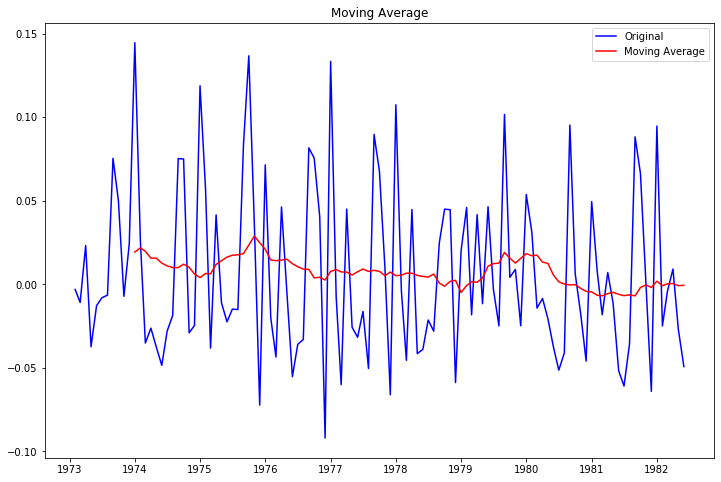

Results of Dickey-Fuller Test:
Test Statistic                  -2.047539
p-value                          0.266126
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [130]:
# 1st difference on log values to remove trend

df['log_first_difference'] = df.riders_log - df.riders_log.shift(1)  
test_stationarity(df.log_first_difference.dropna(inplace=False))

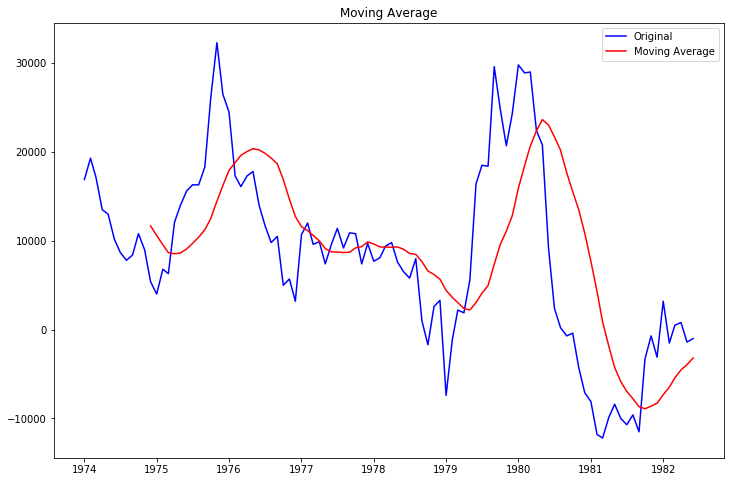

Results of Dickey-Fuller Test:
Test Statistic                 -2.469741
p-value                         0.123011
#Lags Used                      3.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64


In [131]:
# Taking seasonal difference for 12 months

df['seasonal_difference'] = df.riders - df.riders.shift(12)  
test_stationarity(df.seasonal_difference.dropna(inplace=False))

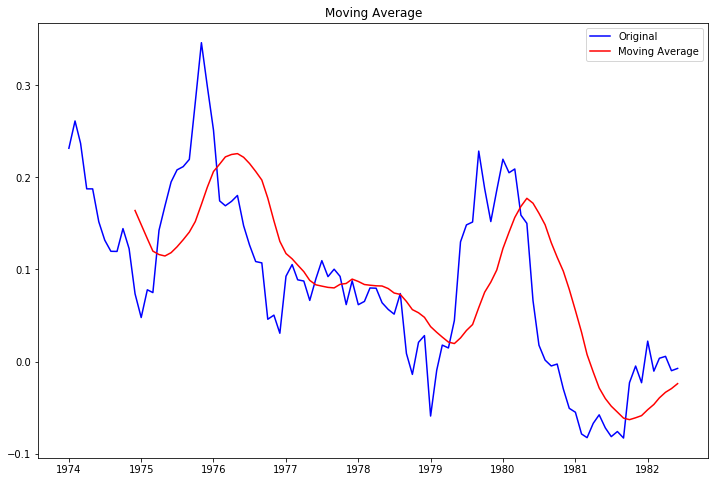

Results of Dickey-Fuller Test:
Test Statistic                  -1.919681
p-value                          0.322860
#Lags Used                       0.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [132]:
# Taking seasonal difference for 12 months on log values

df['log_seasonal_difference'] = df.riders_log - df.riders_log.shift(12)  
test_stationarity(df.log_seasonal_difference.dropna(inplace=False))

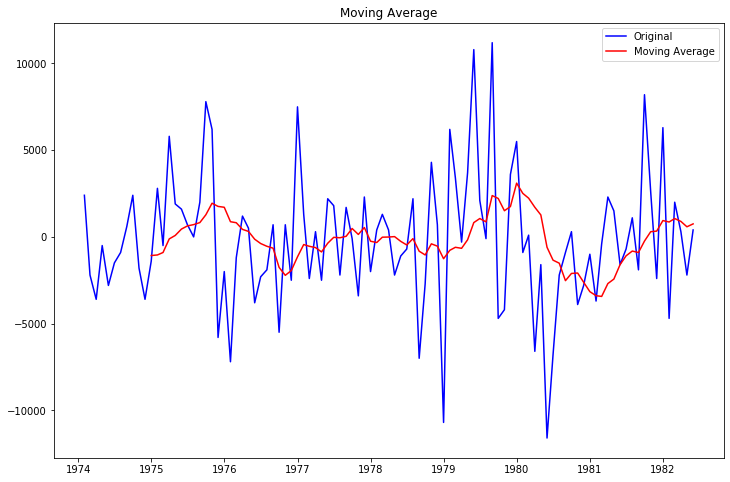

Results of Dickey-Fuller Test:
Test Statistic                -9.258520e+00
p-value                        1.427874e-15
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


In [133]:
# Seasonal first difference to remove seasonality

df['seasonal_first_difference'] = df.first_difference - df.first_difference.shift(12)  
test_stationarity(df.seasonal_first_difference.dropna(inplace=False))

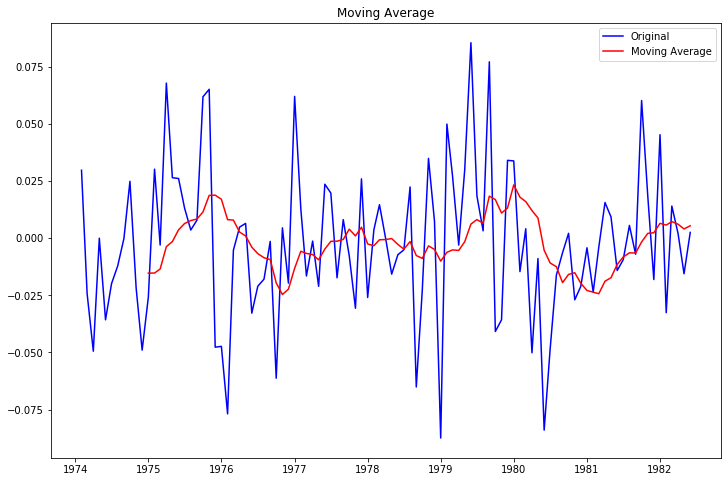

Results of Dickey-Fuller Test:
Test Statistic                -8.882112e+00
p-value                        1.309452e-14
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


In [134]:
# Seasonal first difference on log values to remove seasonality

df['log_seasonal_first_difference'] = df.log_first_difference - df.log_first_difference.shift(12)  
test_stationarity(df.log_seasonal_first_difference.dropna(inplace=False))

**As we can see by the p-value, taking the seasonal first difference has now made our data stationary. By doing this differencing for the log values, but it didn’t make the data any more stationary.**

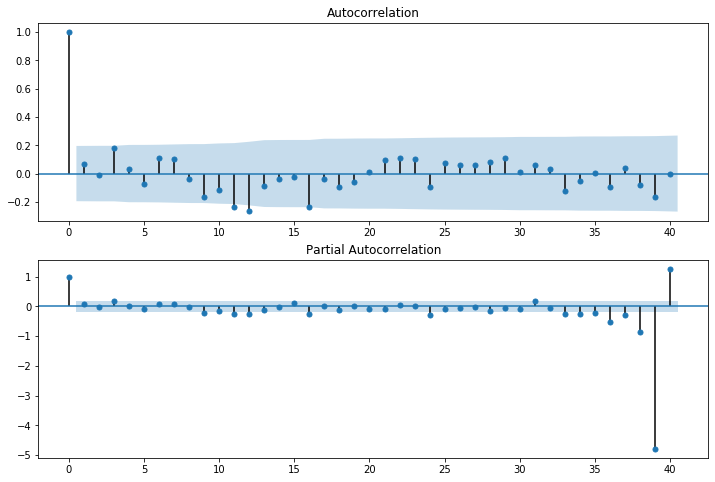

In [137]:
# Plotting ACF and PACF graphs

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

In [138]:
# Buliding the model for SARIMA(0,1,0),(0,1,1,12)
mod = sm.tsa.statespace.SARIMAX(df.riders, order=(0,1,0), seasonal_order=(0,1,1,12))
results = mod.fit()
print (results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             riders   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -976.135
Date:                            Sun, 12 Jan 2020   AIC                           1956.271
Time:                                    16:42:02   BIC                           1961.501
Sample:                                01-01-1973   HQIC                          1958.388
                                     - 06-01-1982                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.1377      0.050     -2.757      0.006      -0.236      -0.040
sigma2      1.424e+07   2.62e-10   

In [140]:
#Buliding the model for SARIMA(0,1,0),(1,1,1,12)

mod = sm.tsa.statespace.SARIMAX(df.riders, order=(0,1,0), seasonal_order=(1,1,1,12))
results = mod.fit()
print (results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             riders   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -970.257
Date:                            Sun, 12 Jan 2020   AIC                           1946.514
Time:                                    16:43:34   BIC                           1954.359
Sample:                                01-01-1973   HQIC                          1949.690
                                     - 06-01-1982                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5590      0.084      6.679      0.000       0.395       0.723
ma.S.L12      -0.9981      0.117   

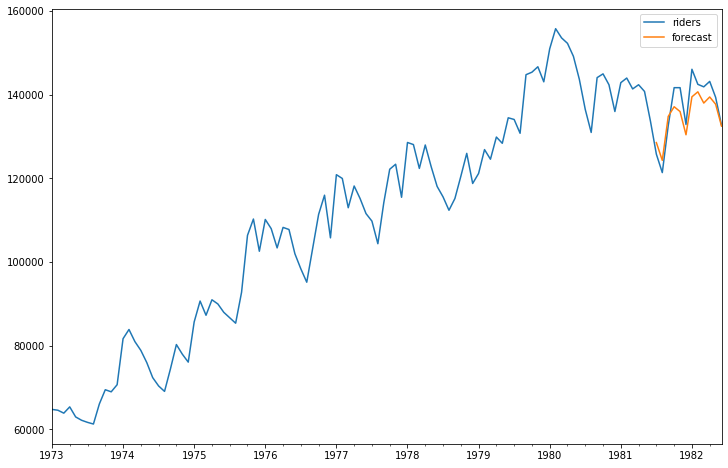

In [141]:
# Forecasting the model and comparing with our test data

df['forecast'] = results.predict(start = 102, end= 114, dynamic= True)  
df[['riders', 'forecast']].plot(figsize=(12, 8)) 
plt.show()

**Conculsion** - So, we can observe from our graph model is quite good to predict observations.